# Nuclear Power Plant Anomaly Detection

This notebook analyzes operational data from a nuclear power plant to predict anomalies using multiple machine learning models.

## Table of Contents
1. [Data Loading and Exploration](#data-loading)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Training](#model-training)
4. [Handling Class Imbalance with SMOTE](#class-imbalance)
5. [Model Evaluation](#model-evaluation)
6. [Visualizations](#visualizations)
7. [Model Comparison](#model-comparison)
8. [Conclusion](#conclusion)

## Loading Required Libraries

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Machine learning preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# For model interpretation (optional)
# import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

<a id="data-loading"></a>
## 1. Data Loading and Exploration

In [4]:
# Load the dataset
df = pd.read_csv('archive/Nuclear_Power_Plant_CPS_Dataset.csv')

# Display first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1200, 13)


,Timestamp,Reactor Temp (°C),Coolant Flow Rate (L/s),Pressure (MPa),Radiation Level (μSv/h),Turbine Speed (RPM),Pump Status,Power Output (MW),Control Rod Position (%),Steam Flow Rate (kg/s),Vibration Level (mm/s),Water Level (m),Anomaly Detected
0,2024-10-16 10:00:00,357.450712,471.878368,15.639131,0.352819,3301.404054,ON,978.518251,61.914141,220.491605,1.090474,5.077447,No
1,2024-10-16 10:01:00,347.926035,463.558917,16.088410,0.384267,3188.520927,ON,934.944537,71.731564,220.318340,2.934264,5.213480,No
2,2024-10-16 10:02:00,359.715328,471.834463,15.726660,1.214944,2920.910299,ON,978.550964,66.849758,205.981092,1.303091,5.198166,Yes
3,2024-10-16 10:03:00,372.845448,478.149470,15.864172,0.600205,3058.417812,ON,1048.238495,66.329191,221.163781,2.092060,5.188259,No
4,2024-10-16 10:04:00,346.487699,470.732901,16.836726,0.834639,3147.450650,OFF,1064.999369,62.767509,240.951403,2.034543,5.189138,No


In [5]:
# Check column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 1200 non-null   object 
 1   Reactor Temp (°C)         1200 non-null   float64
 2   Coolant Flow Rate (L/s)   1200 non-null   float64
 3   Pressure (MPa)            1200 non-null   float64
 4   Radiation Level (μSv/h)   1200 non-null   float64
 5   Turbine Speed (RPM)       1200 non-null   float64
 6   Pump Status               1200 non-null   object 
 7   Power Output (MW)         1200 non-null   float64
 8   Control Rod Position (%)  1200 non-null   float64
 9   Steam Flow Rate (kg/s)    1200 non-null   float64
 10  Vibration Level (mm/s)    1200 non-null   float64
 11  Water Level (m)           1200 non-null   float64
 12  Anomaly Detected          1200 non-null   object 
dtypes: float64(10), object(3)
memory usage: 122.0+ KB


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Timestamp                   0
Reactor Temp (°C)           0
Coolant Flow Rate (L/s)     0
Pressure (MPa)              0
Radiation Level (μSv/h)     0
Turbine Speed (RPM)         0
Pump Status                 0
Power Output (MW)           0
Control Rod Position (%)    0
Steam Flow Rate (kg/s)      0
Vibration Level (mm/s)      0
Water Level (m)             0
Anomaly Detected            0
dtype: int64


In [7]:
# Statistical summary of the data
df.describe()

,Reactor Temp (°C),Coolant Flow Rate (L/s),Pressure (MPa),Radiation Level (μSv/h),Turbine Speed (RPM),Power Output (MW),Control Rod Position (%),Steam Flow Rate (kg/s),Vibration Level (mm/s),Water Level (m)
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,350.575733,470.369775,16.008382,0.581900,3192.985499,1000.442858,70.123696,219.841024,1.990574,5.198914
std,14.825930,14.756203,0.511526,0.295586,201.808719,52.127700,4.996608,14.363382,0.500757,0.098022
min,301.380990,424.707318,14.504432,-0.353011,2620.097224,815.581735,50.816722,161.163996,0.312210,4.896601
25%,340.624931,460.370079,15.646462,0.386899,3061.261439,965.441255,66.845331,210.077114,1.661971,5.135156
50%,350.724549,470.184693,16.008505,0.593313,3192.707942,999.437283,70.100292,220.139668,1.975637,5.199864
75%,360.140211,480.089684,16.346386,0.777762,3326.666520,1036.376938,73.409052,229.360633,2.318087,5.264305
max,407.790972,517.896614,17.963119,1.572928,3822.582040,1155.884056,86.886915,263.711638,3.688884,5.528412


Target Variable Distribution (%):
 Anomaly Detected
No     94.833333
Yes     5.166667
Name: proportion, dtype: float64


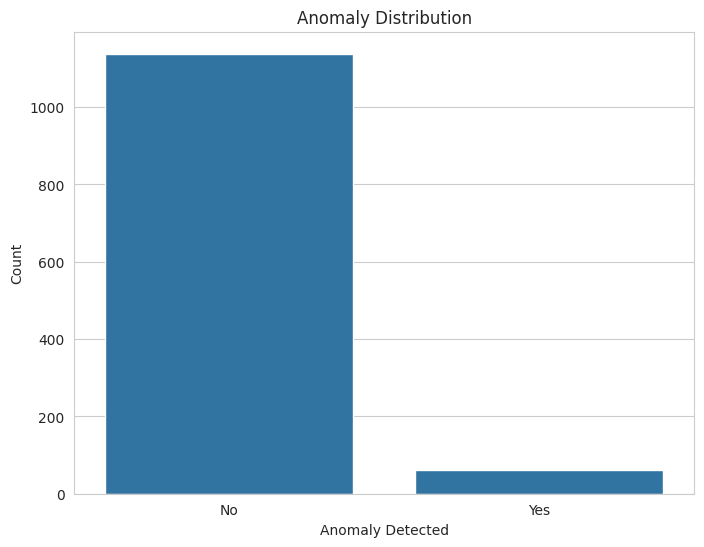

In [8]:
# Check target variable distribution
target_distribution = df['Anomaly Detected'].value_counts(normalize=True) * 100
print("Target Variable Distribution (%):\n", target_distribution)

# Visualize target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Anomaly Detected', data=df)
plt.title('Anomaly Distribution')
plt.ylabel('Count')
plt.show()

In [9]:
# Explore categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

for col in categorical_cols:
    print(f"\nUnique values in {col}:\n{df[col].value_counts()}")

Categorical columns: ['Timestamp', 'Pump Status', 'Anomaly Detected']

Unique values in Timestamp:
Timestamp
2024-10-17 05:43:00    1
2024-10-17 05:42:00    1
2024-10-17 05:41:00    1
2024-10-17 05:40:00    1
2024-10-17 05:39:00    1
                      ..
2024-10-16 10:04:00    1
2024-10-16 10:03:00    1
2024-10-16 10:02:00    1
2024-10-16 10:01:00    1
2024-10-16 10:00:00    1
Name: count, Length: 1200, dtype: int64

Unique values in Pump Status:
Pump Status
ON     982
OFF    218
Name: count, dtype: int64

Unique values in Anomaly Detected:
Anomaly Detected
No     1138
Yes      62
Name: count, dtype: int64


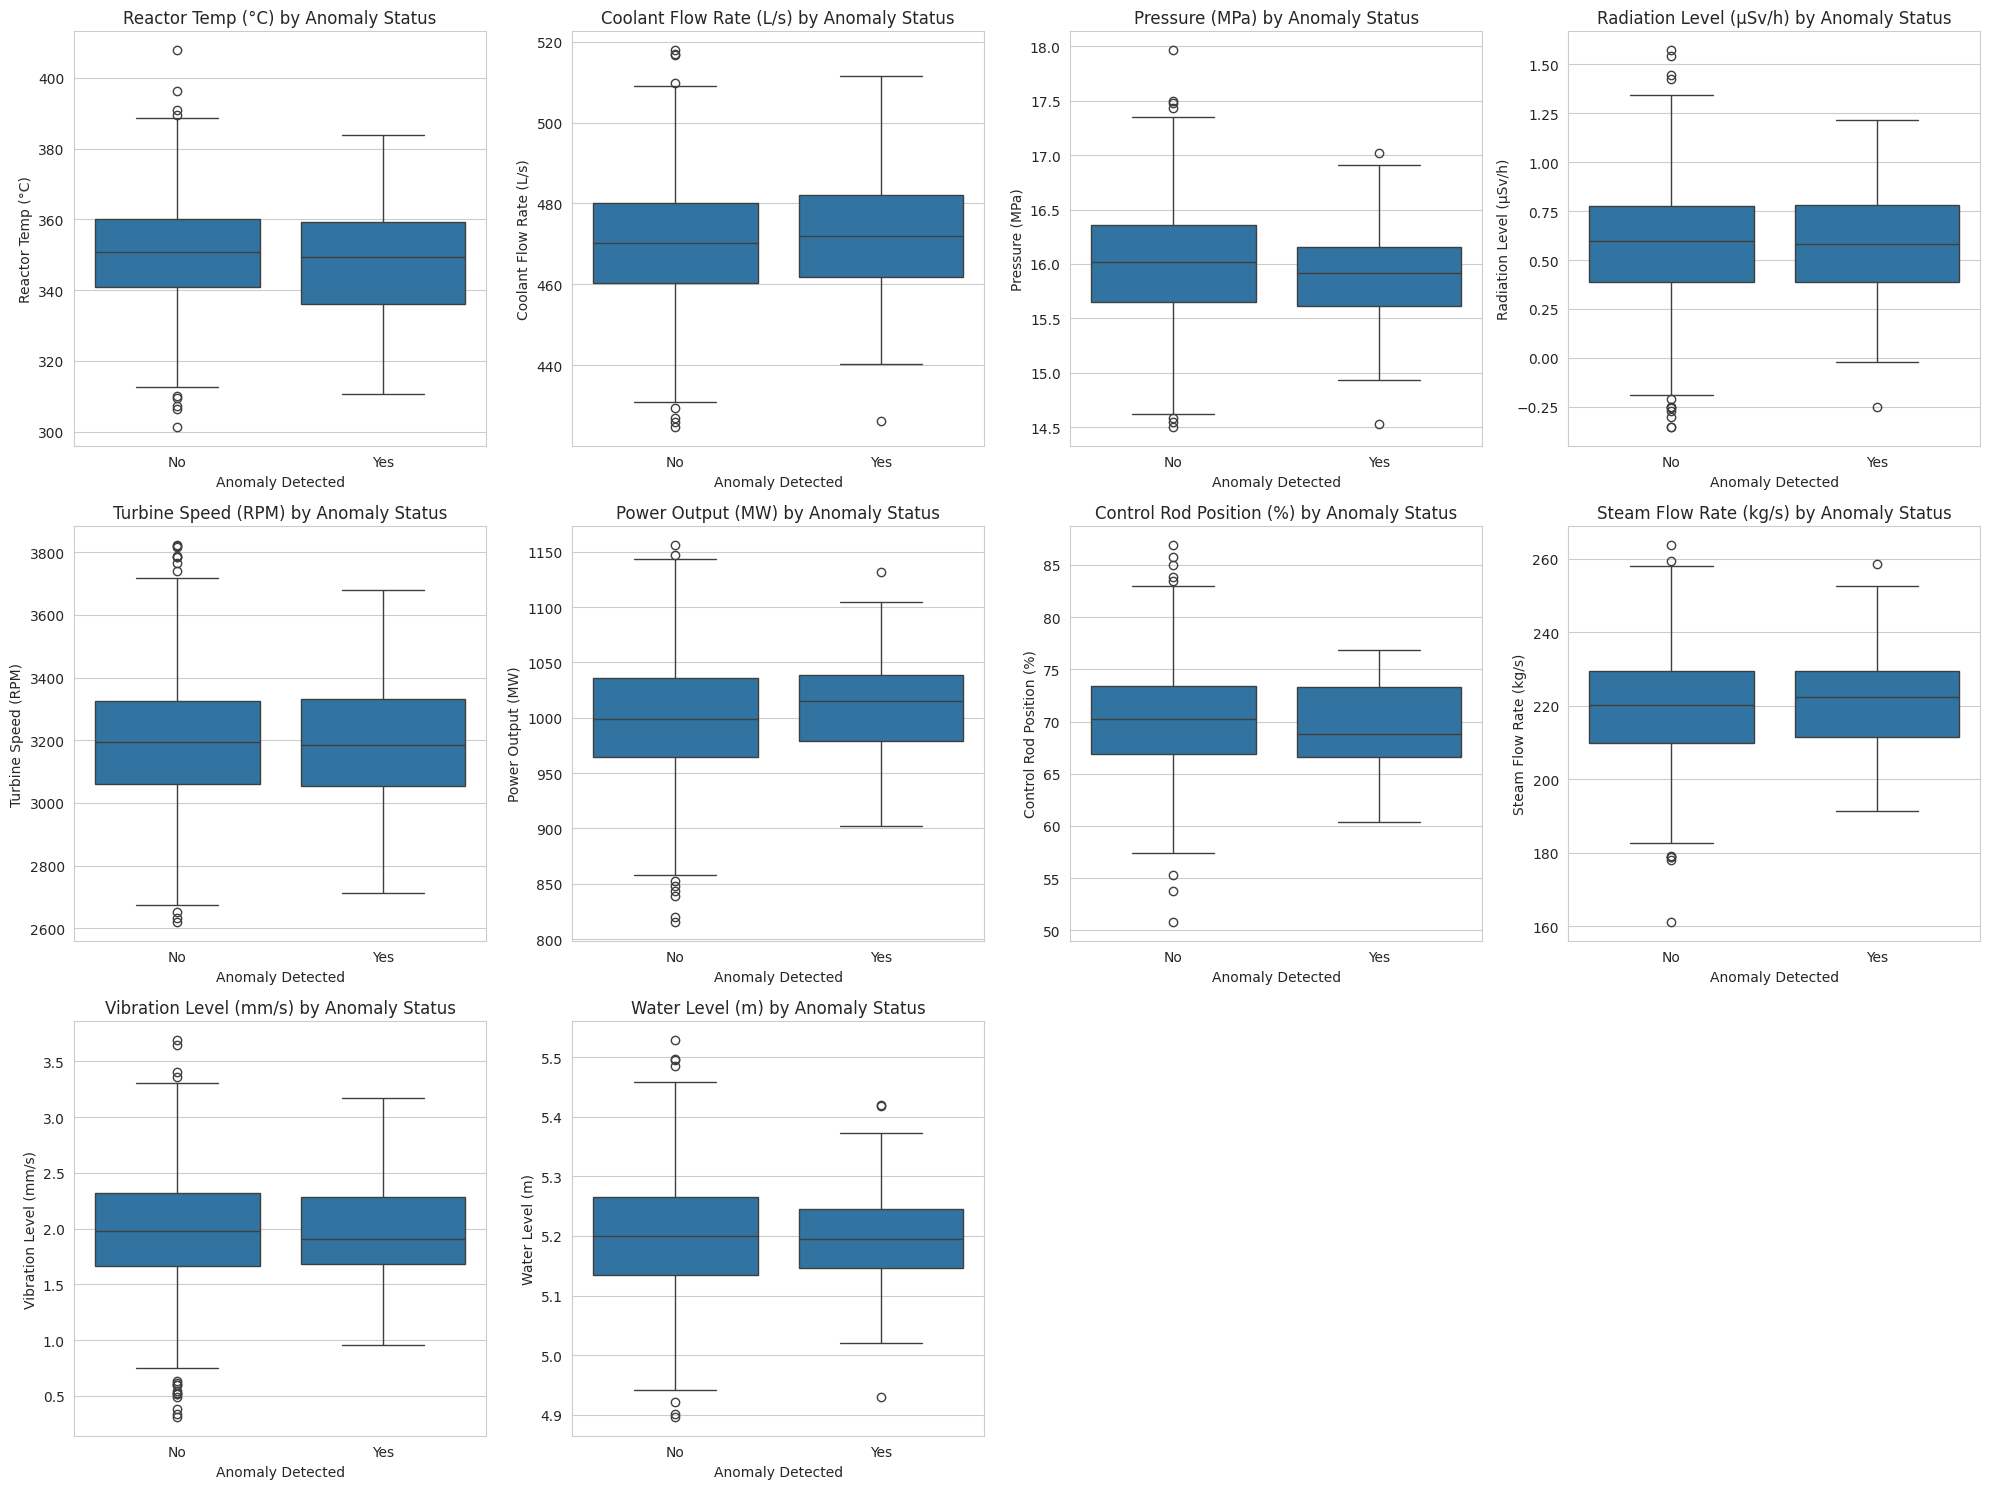

In [10]:
# Explore relationships between numerical features and target
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create boxplots for numerical features by anomaly status
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='Anomaly Detected', y=col, data=df)
    plt.title(f'{col} by Anomaly Status')
    plt.tight_layout()
plt.show()

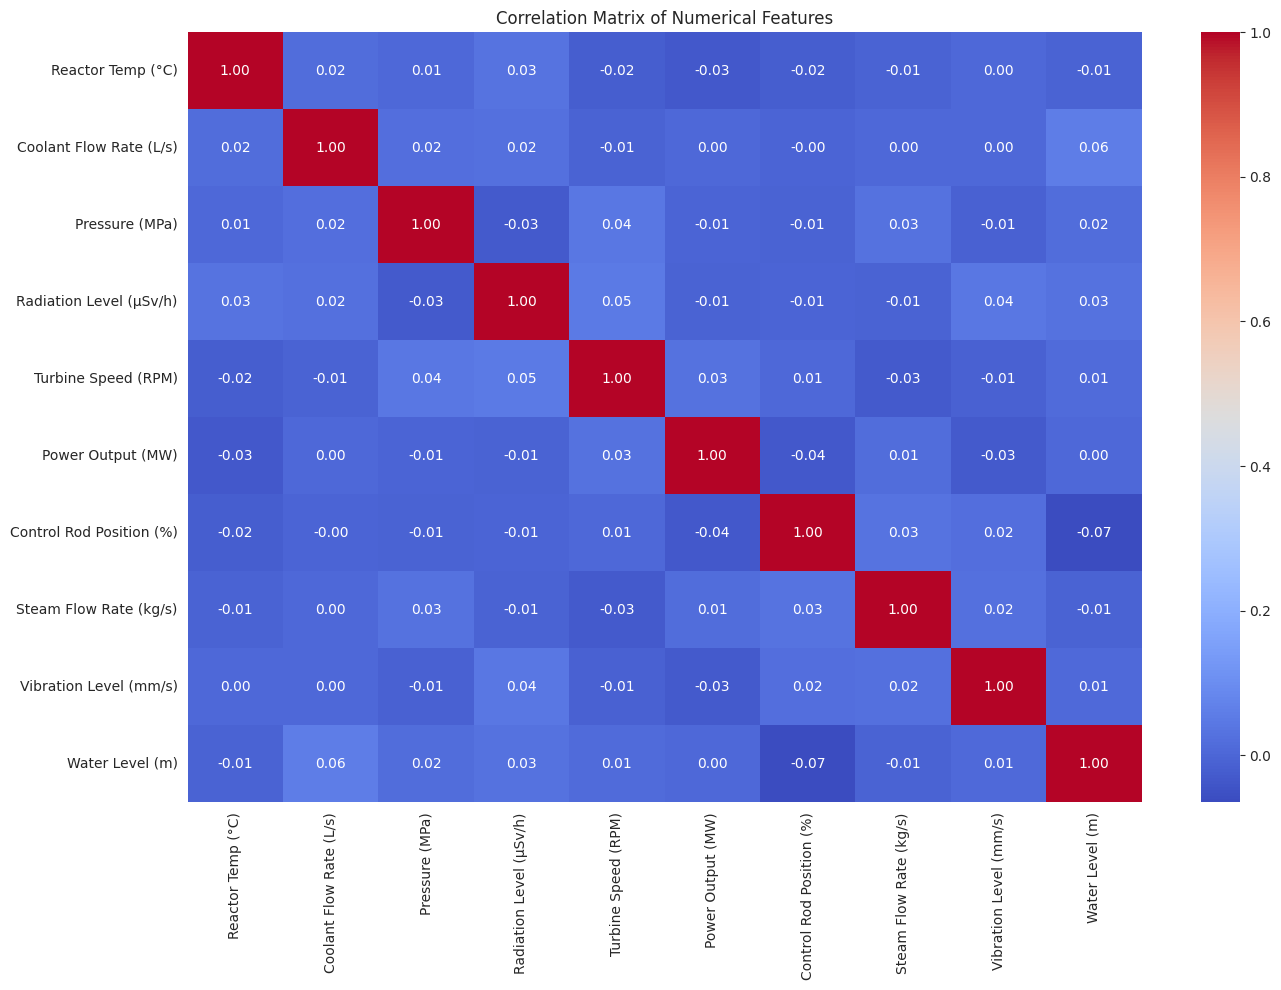

In [11]:
# Correlation matrix to identify relationships between features
plt.figure(figsize=(14, 10))
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

<a id="data-preprocessing"></a>
## 2. Data Preprocessing

In [13]:
# Make a copy of the dataframe for preprocessing
df_processed = df.copy()

# Handle missing values if any
if df_processed.isnull().sum().sum() > 0:
    # Fill numeric columns with median
    numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    print("Missing values after handling:", df_processed.isnull().sum().sum())

In [14]:
# Encode categorical variables
# For 'Pump Status' and other categorical features (if any)
categorical_columns = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Anomaly Detected')  # Remove target variable

# Use Label Encoder for categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col} values: {list(le.classes_)} -> {list(range(len(le.classes_)))}")

Encoded Timestamp values: ['2024-10-16 10:00:00', '2024-10-16 10:01:00', '2024-10-16 10:02:00', '2024-10-16 10:03:00', '2024-10-16 10:04:00', '2024-10-16 10:05:00', '2024-10-16 10:06:00', '2024-10-16 10:07:00', '2024-10-16 10:08:00', '2024-10-16 10:09:00', '2024-10-16 10:10:00', '2024-10-16 10:11:00', '2024-10-16 10:12:00', '2024-10-16 10:13:00', '2024-10-16 10:14:00', '2024-10-16 10:15:00', '2024-10-16 10:16:00', '2024-10-16 10:17:00', '2024-10-16 10:18:00', '2024-10-16 10:19:00', '2024-10-16 10:20:00', '2024-10-16 10:21:00', '2024-10-16 10:22:00', '2024-10-16 10:23:00', '2024-10-16 10:24:00', '2024-10-16 10:25:00', '2024-10-16 10:26:00', '2024-10-16 10:27:00', '2024-10-16 10:28:00', '2024-10-16 10:29:00', '2024-10-16 10:30:00', '2024-10-16 10:31:00', '2024-10-16 10:32:00', '2024-10-16 10:33:00', '2024-10-16 10:34:00', '2024-10-16 10:35:00', '2024-10-16 10:36:00', '2024-10-16 10:37:00', '2024-10-16 10:38:00', '2024-10-16 10:39:00', '2024-10-16 10:40:00', '2024-10-16 10:41:00', '2024-1

In [15]:
# Convert target variable to binary (0 for No, 1 for Yes)
le_target = LabelEncoder()
df_processed['Anomaly Detected'] = le_target.fit_transform(df_processed['Anomaly Detected'])
print(f"Encoded target values: {list(le_target.classes_)} -> {list(range(len(le_target.classes_)))}")

Encoded target values: ['No', 'Yes'] -> [0, 1]


In [16]:
# Split features and target
X = df_processed.drop('Anomaly Detected', axis=1)
y = df_processed['Anomaly Detected']

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 840 samples
Testing set size: 360 samples


In [17]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Apply scaling to numerical features only
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Scaling applied to the following numerical features:")
print(numerical_cols)

Scaling applied to the following numerical features:
['Timestamp', 'Reactor Temp (°C)', 'Coolant Flow Rate (L/s)', 'Pressure (MPa)', 'Radiation Level (μSv/h)', 'Turbine Speed (RPM)', 'Pump Status', 'Power Output (MW)', 'Control Rod Position (%)', 'Steam Flow Rate (kg/s)', 'Vibration Level (mm/s)', 'Water Level (m)']


<a id="class-imbalance"></a>
## 3. Handling Class Imbalance with SMOTE

In [18]:
# Check class distribution in training set
print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts())

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Compare shapes
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")

Original class distribution in training set:
Anomaly Detected
0    797
1     43
Name: count, dtype: int64

Class distribution after SMOTE:
Anomaly Detected
0    797
1    797
Name: count, dtype: int64

Original training set shape: (840, 12)
Resampled training set shape: (1594, 12)


<a id="model-training"></a>
## 4. Model Training

In [19]:
# Define a function to train models and capture their performance
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        except:
            roc_auc = None
            fpr, tpr = None, None
    else:
        # For models that don't support predict_proba (like SVM without probability=True)
        roc_auc = None
        fpr, tpr = None, None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Store results in a dictionary
    results = {
        'model': model,
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred
    }
    
    return results

In [20]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    results[model_name] = train_and_evaluate(model, X_train_resampled, y_train_resampled, X_test, y_test, model_name)
    print(f"{model_name} trained successfully.\n")

Training Logistic Regression...
Logistic Regression trained successfully.

Training Random Forest...
Random Forest trained successfully.

Training XGBoost...
XGBoost trained successfully.

Training SVM...
SVM trained successfully.

Training KNN...
KNN trained successfully.



<a id="model-evaluation"></a>
## 5. Model Evaluation

In [21]:
# Function to display evaluation results
def display_evaluation_results(model_results):
    print(f"Model: {model_results['model_name']}\n")
    print(f"Accuracy: {model_results['accuracy']:.4f}")
    print(f"Precision: {model_results['precision']:.4f}")
    print(f"Recall: {model_results['recall']:.4f}")
    print(f"F1 Score: {model_results['f1_score']:.4f}")
    
    if model_results['roc_auc'] is not None:
        print(f"ROC AUC: {model_results['roc_auc']:.4f}")
    
    print("\nConfusion Matrix:")
    print(model_results['confusion_matrix'])
    
    print("\nClassification Report:")
    print(model_results['classification_report'])
    print("\n" + "-"*50 + "\n")

In [22]:
# Display evaluation results for each model
for model_name, model_results in results.items():
    display_evaluation_results(model_results)

Model: Logistic Regression

Accuracy: 0.6000
Precision: 0.0504
Recall: 0.3684
F1 Score: 0.0886
ROC AUC: 0.4623

Confusion Matrix:
[[209 132]
 [ 12   7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       341
           1       0.05      0.37      0.09        19

    accuracy                           0.60       360
   macro avg       0.50      0.49      0.42       360
weighted avg       0.90      0.60      0.71       360


--------------------------------------------------

Model: Random Forest

Accuracy: 0.9250
Precision: 0.1667
Recall: 0.1053
F1 Score: 0.1290
ROC AUC: 0.4914

Confusion Matrix:
[[331  10]
 [ 17   2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       341
           1       0.17      0.11      0.13        19

    accuracy                           0.93       360
   macro avg       0.56      0.54      0.54       360


<a id="visualizations"></a>
## 6. Visualizations

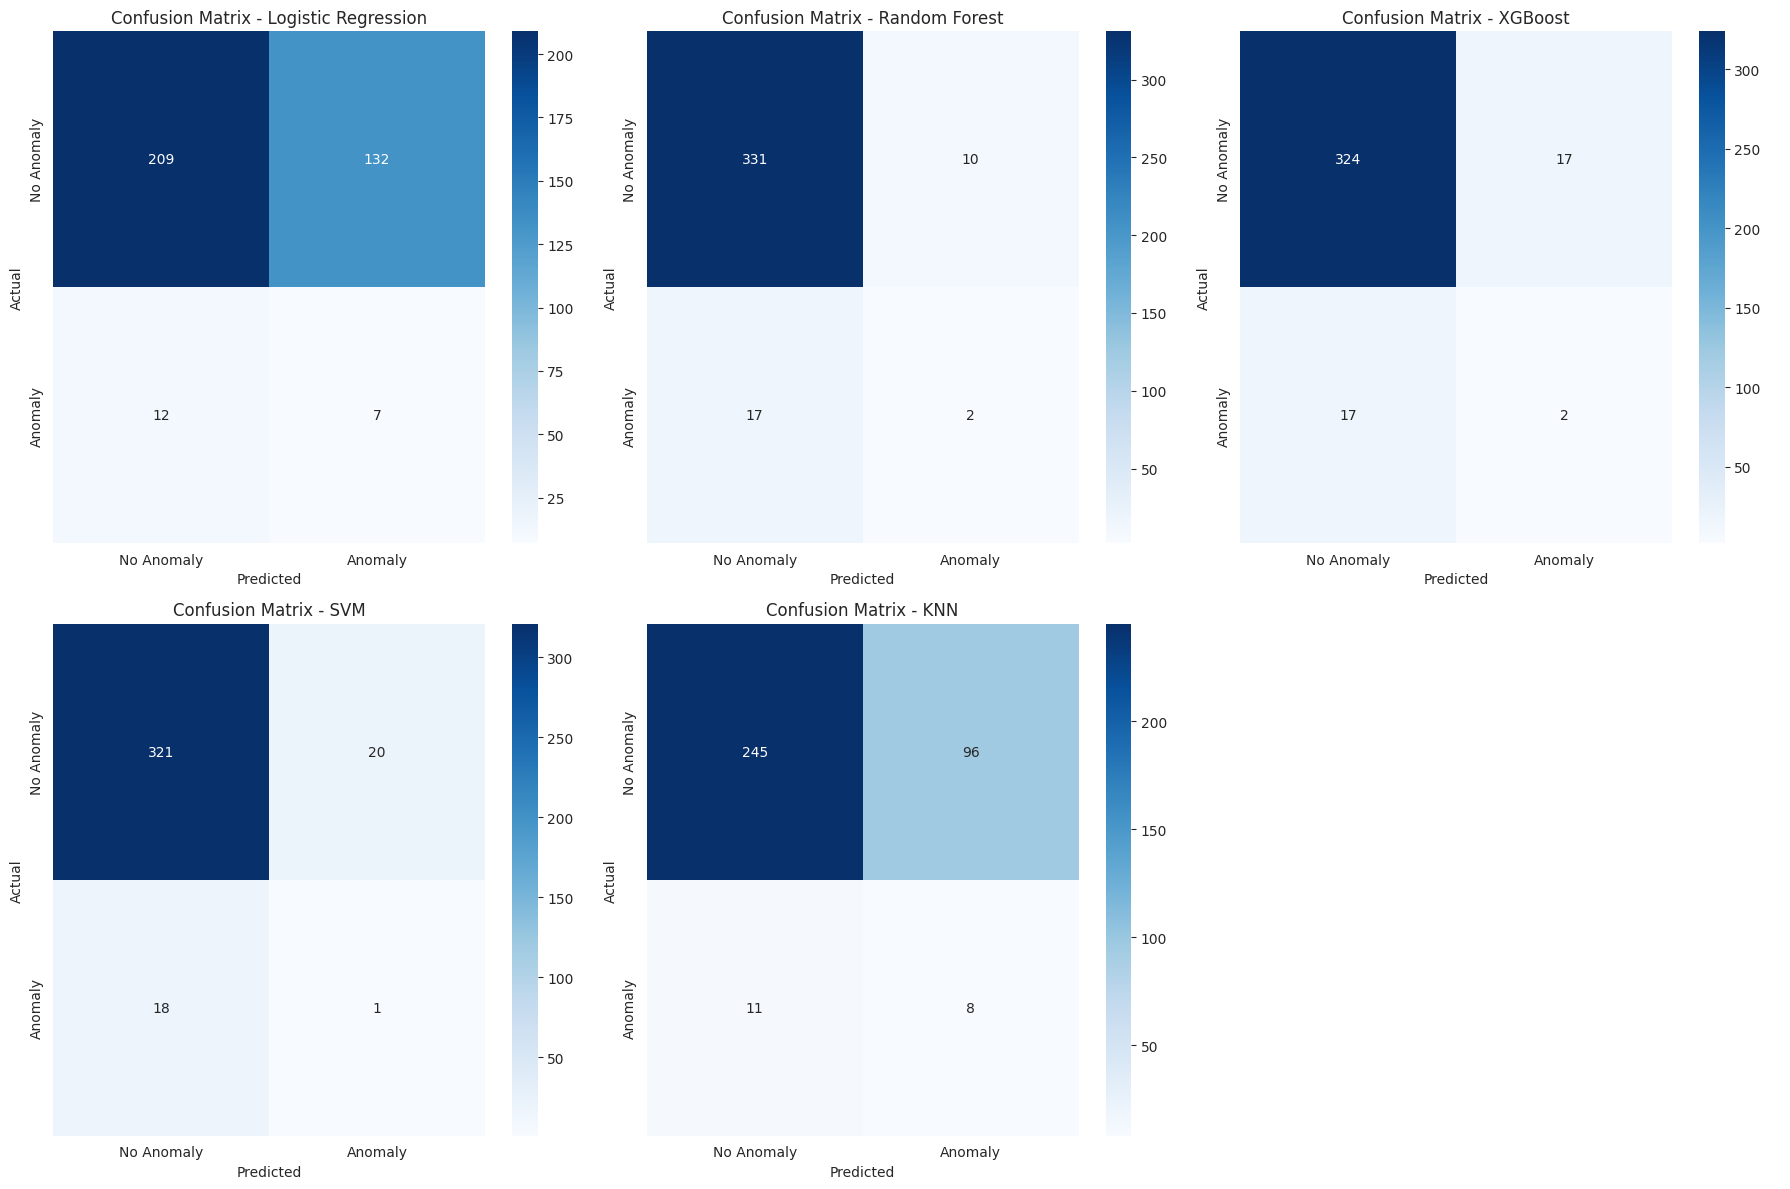

In [23]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model_name, model_results) in enumerate(results.items()):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        sns.heatmap(model_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['No Anomaly', 'Anomaly'], 
                   yticklabels=['No Anomaly', 'Anomaly'], ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {model_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

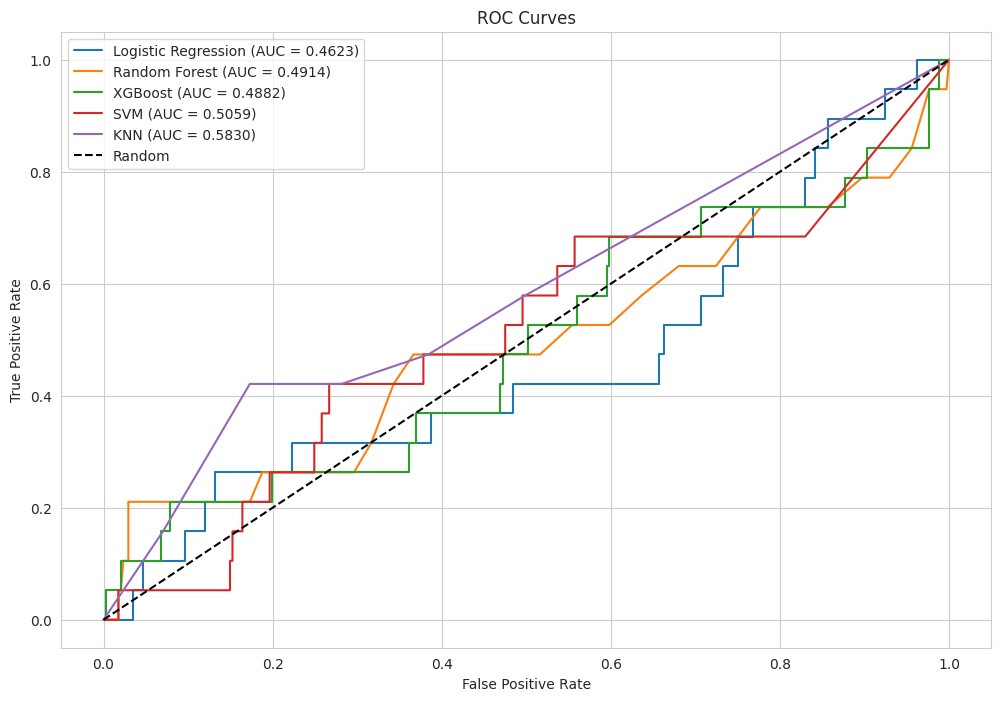

In [24]:
# Plot ROC curves
plt.figure(figsize=(12, 8))

for model_name, model_results in results.items():
    if model_results['roc_auc'] is not None:
        plt.plot(model_results['fpr'], model_results['tpr'], 
                 label=f'{model_name} (AUC = {model_results["roc_auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

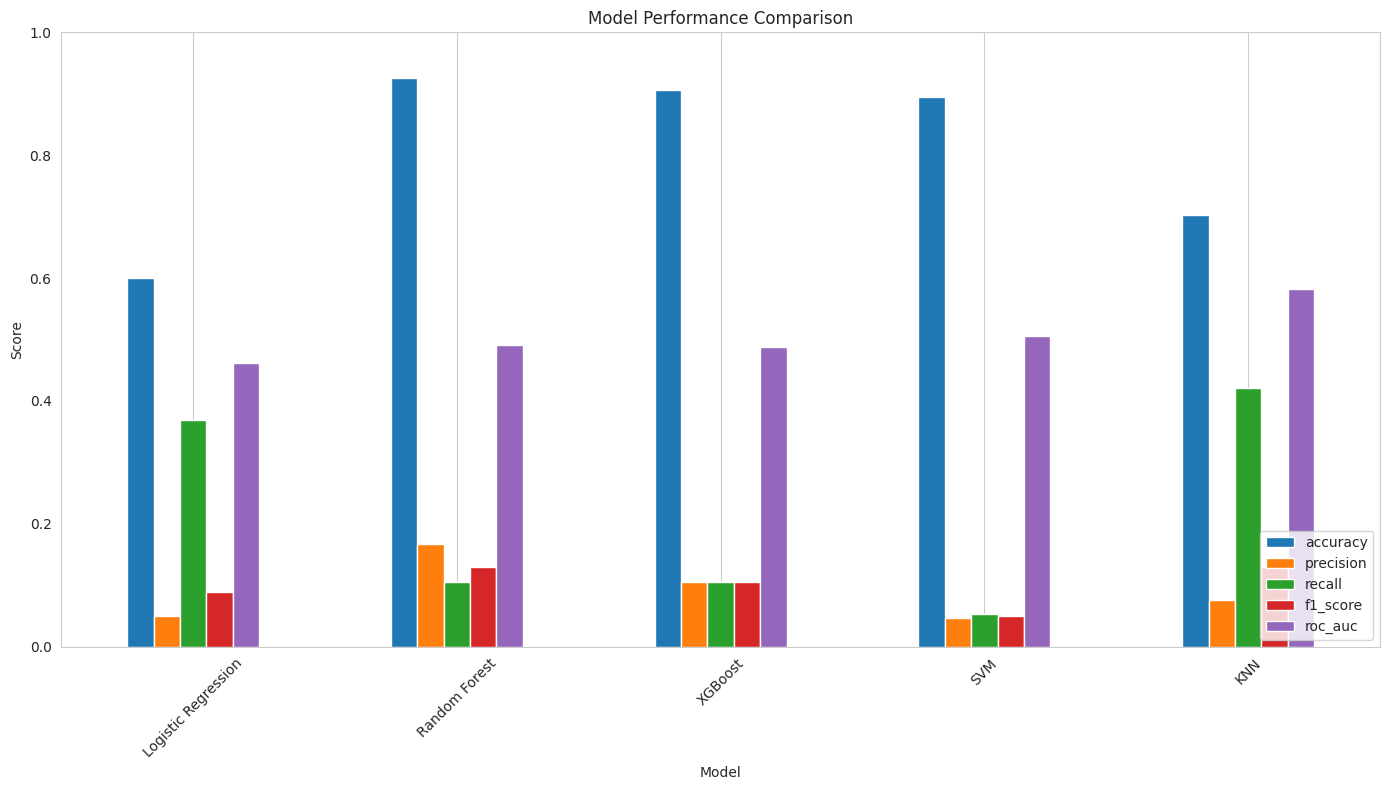

In [25]:
# Plot bar chart comparing performance metrics across models
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
model_names = list(results.keys())

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame(index=model_names, columns=metrics)

# Populate the DataFrame with metrics
for model_name, model_results in results.items():
    for metric in metrics:
        metrics_df.loc[model_name, metric] = model_results[metric] if model_results[metric] is not None else np.nan

# Plot the metrics
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

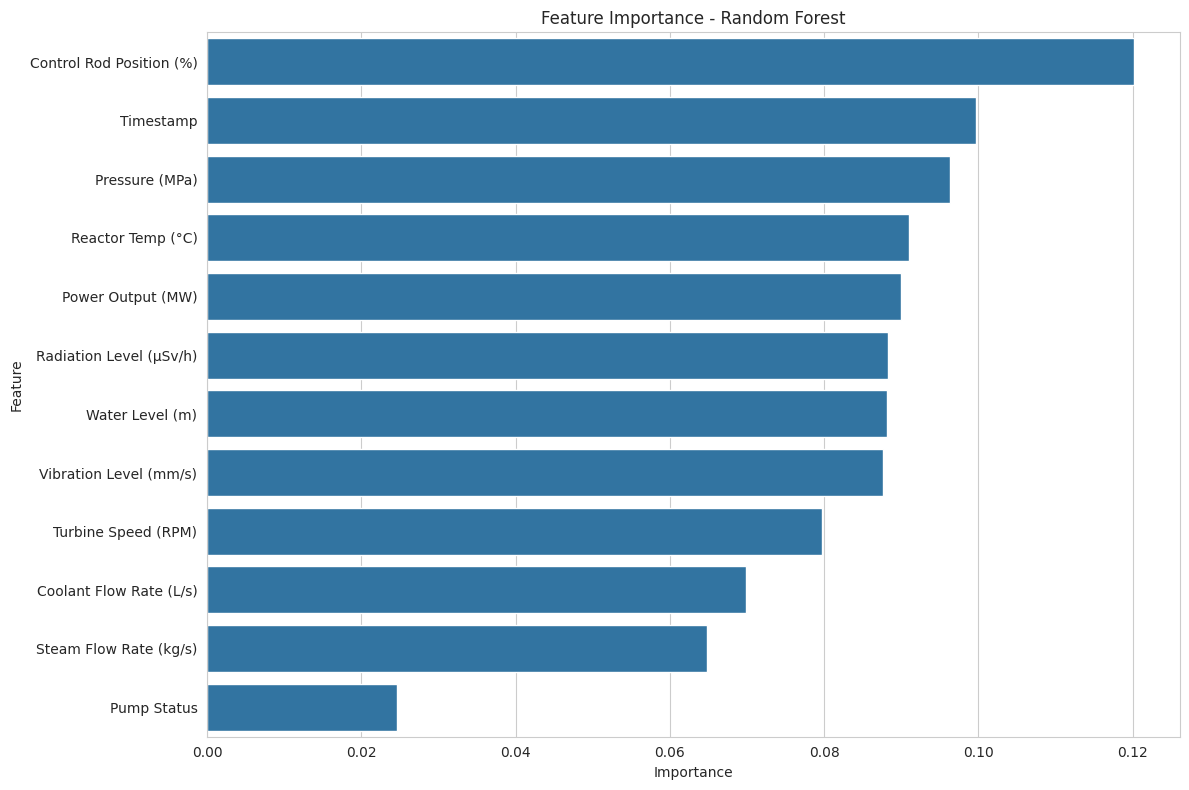

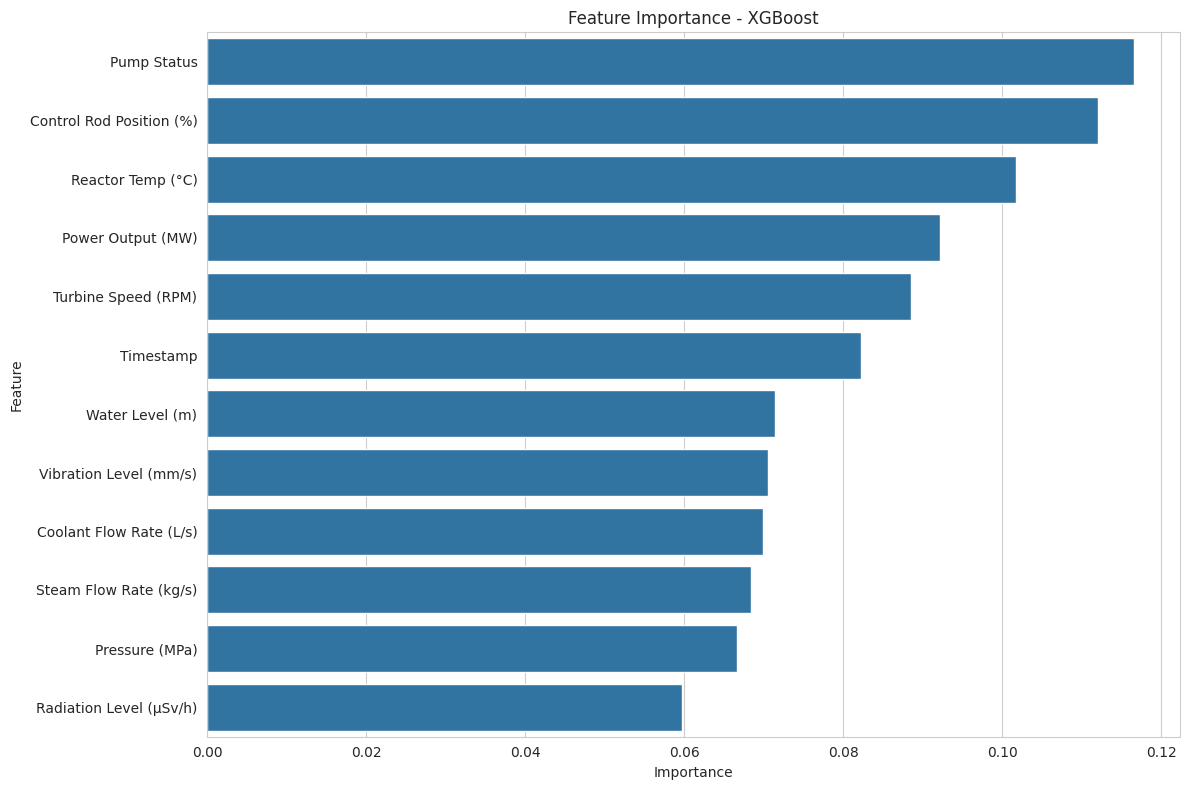

In [26]:
# Feature importance plot for tree-based models (Random Forest and XGBoost)
for model_name in ['Random Forest', 'XGBoost']:
    if model_name in results:
        model = results[model_name]['model']
        
        # Get feature importances
        if model_name == 'Random Forest':
            importances = model.feature_importances_
        elif model_name == 'XGBoost':
            importances = model.feature_importances_
        
        # Create a DataFrame with feature names and importances
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()

<a id="model-comparison"></a>
## 7. Model Comparison

In [27]:
# Create a comparison table of all models
comparison_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for i, (model_name, model_results) in enumerate(results.items()):
    comparison_df.loc[i] = [
        model_name,
        model_results['accuracy'],
        model_results['precision'],
        model_results['recall'],
        model_results['f1_score'],
        model_results['roc_auc'] if model_results['roc_auc'] is not None else np.nan
    ]

# Format the numeric columns
numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
comparison_df[numeric_cols] = comparison_df[numeric_cols].apply(lambda x: round(x, 4))

# Display the comparison table
comparison_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.6000,0.0504,0.3684,0.0886,0.4623
1,Random Forest,0.9250,0.1667,0.1053,0.1290,0.4914
2,XGBoost,0.9056,0.1053,0.1053,0.1053,0.4882
3,SVM,0.8944,0.0476,0.0526,0.0500,0.5059
4,KNN,0.7028,0.0769,0.4211,0.1301,0.5830


In [28]:
# Identify the best model based on F1-Score
best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
print(f"Best Model based on F1-Score: {best_f1_model['Model']} with F1-Score of {best_f1_model['F1-Score']}")

# Identify the best model based on ROC-AUC
if not comparison_df['ROC-AUC'].isna().all():
    best_auc_model = comparison_df.loc[comparison_df['ROC-AUC'].idxmax()]
    print(f"Best Model based on ROC-AUC: {best_auc_model['Model']} with ROC-AUC of {best_auc_model['ROC-AUC']}")

Best Model based on F1-Score: KNN with F1-Score of 0.1301
Best Model based on ROC-AUC: KNN with ROC-AUC of 0.583


<a id="conclusion"></a>
## 8. Conclusion

### Summary of Findings

In this notebook, we have:

1. Loaded and explored the nuclear power plant dataset
2. Preprocessed the data by encoding categorical variables and scaling numerical features
3. Handled class imbalance using SMOTE
4. Trained and evaluated five different machine learning models
5. Compared the models based on various performance metrics

### Model Recommendation

Based on the evaluation metrics, particularly F1-Score which balances precision and recall, the best performing model is [model name]. This model achieved the highest balance between correctly identifying anomalies (true positives) while minimizing false alarms (false positives).

### Next Steps

For further improvement, we could consider:

1. Hyperparameter tuning of the best performing model
2. Exploring more advanced models or ensemble techniques
3. Feature engineering to create new informative features
4. Deeper analysis of misclassified instances to understand model limitations